In [2]:
import os
os.environ["HF_TOKEN"] = "YOUR_TOKEN_HERE"

In [3]:
import json

In [4]:
from huggingface_hub import login
login(os.environ["HF_TOKEN"])


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Llama 3 8B for labelling data

In [5]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [17]:
print(torch.cuda.device_count())  # Số lượng GPU
print(torch.cuda.get_device_name(0))  # Tên GPU thứ nhất
print(torch.cuda.get_device_name(1))  # Tên GPU thứ hai


2
Tesla T4
Tesla T4


In [27]:
import json

# Hàm xử lý một câu để trích xuất thực thể
def process_sentence(sentence, pipeline):
    """Trích xuất thực thể từ một câu và định dạng JSON."""
    messages = [
        {"role": "system", "content": 
         "Bạn là một mô hình AI chuyên trích xuất thực thể. Trả về kết quả theo định dạng JSON với cấu trúc:\n"
         "{\n"
         "  \"sentence\": \"<câu đầu vào giữ nguyên cấu trúc>\",\n"
         "  \"entities\": {\n"
         "    {\"<nhãn>\": [\"<thực thể>\"]},\n"
         "    ...\n"
         "  }\n"
         "}\n"
         "Chỉ sử dụng các nhãn sau: \"technology\", \"Datetime\", \"Organization\", \"Person\". Không thêm bất kỳ văn bản nào ngoài JSON."},
        {"role": "user", "content": sentence}
    ]

    # Áp dụng tokenizer và định dạng prompt
    prompt = pipeline.tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = pipeline(
        prompt,
        max_new_tokens=256,
        eos_token_id=terminators,
        pad_token_id=pipeline.tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    generated_text = outputs[0]["generated_text"][len(prompt):].strip()
    # return generated_text
    try:
        json_start_index = generated_text.find('{')
        json_end_index = generated_text.rfind('}')
        if json_start_index != -1 and json_end_index != -1:
            json_content = generated_text[json_start_index:json_end_index + 1]
            return json.loads(json_content)
        else:
            raise ValueError("Không tìm thấy JSON hợp lệ.")
    except (json.JSONDecodeError, ValueError) as e:
        print(f"Lỗi: {e}\nĐầu ra không hợp lệ: {generated_text}")
        return {"sentence": sentence, "entities": []}

file_path = "/kaggle/input/news-crawling-data/news.txt"
output_path = "output3.json"

results = []

with open(file_path, 'r', encoding='utf-8') as input_file:
    for line in input_file:
        sentence = line.strip()
        if not sentence:
            continue
        
        extracted_data = process_sentence(sentence, pipeline)
        print(extracted_data)
        results.append(extracted_data)

with open(output_path, 'w', encoding='utf-8') as output_file:
    json.dump(results, output_file, ensure_ascii=False, indent=2)

print(f"Kết quả đã được lưu tại: {output_path}")


{'sentence': 'Rất khó làm chủ về độ chính xác và đồng bộ của các phần tử khi phát và thu, ông Trần Hoàng Việt, trưởng phòng Công nghệ ăng-ten mảng pha chủ động của VHT, cho biết.', 'entities': {'Person': ['Trần Hoàng Việt'], 'Organization': ['VHT']}}
{'sentence': 'Các chuyên gia của Viettel cho biết chọn nghiên cứu công nghệ ăng-ten mảng pha quét búp sóng điện tử (beamforming), tương tự công nghệ được ứng dụng trong phát sóng 5G.', 'entities': {'Organization': ['Viettel'], 'Technology': ['beamforming', '5G']}}
{'sentence': 'Công nghệ này sử dụng các phần tử ăng-ten khác nhau hoạt động đồng bộ để điều chỉnh hướng phát và nhận sóng của radar.', 'entities': {'technology': ['phần tử ăng-ten', 'radar']}}
{'sentence': 'Cách này tạo ra độ phân giải cao hơn so với việc phát tín hiệu ra tất cả hướng của radar truyền thống.', 'entities': {'technology': ['radar']}}
{'sentence': 'Các sản phẩm được trưng bày tại Triển lãm Quốc phòng ở Hà Nội ngày 19-22/12, thu hút sự chú ý lớn từ khách tham quan, v

In [35]:
from nltk.tokenize import word_tokenize

input_file = "/kaggle/working/output3.json"
output_file = "training_data.txt"

def json_to_training_data(json_data):
    training_data = []
    valid_entity_types = {"person", "organization", "technology", "datetime"}
    
    for item in json_data:
        sentence = item["sentence"]
        entities = item["entities"]
        tokens = word_tokenize(sentence)
        tags = ["O"] * len(tokens)
        if isinstance(entities, dict):
            for entity_type, entity_values in entities.items():
                if entity_type.lower() not in valid_entity_types:
                    continue
                if isinstance(entity_values, str):
                    entity_values = [entity_values]

                for entity in entity_values:
                    entity_tokens = word_tokenize(entity)
                    entity_length = len(entity_tokens)

                    for i in range(len(tokens) - entity_length + 1):
                        if tokens[i:i + entity_length] == entity_tokens:
                            tags[i] = f"B-{entity_type.capitalize()}"
                            for j in range(1, entity_length):
                                if i + j < len(tags):
                                    tags[i + j] = f"I-{entity_type.capitalize()}"
                            break

        for token, tag in zip(tokens, tags):
            training_data.append(f"{token} {tag}")
        training_data.append("")

    return "\n".join(training_data)

with open(input_file, "r", encoding="utf-8") as f:
    json_data = json.load(f)

training_data = json_to_training_data(json_data)

with open(output_file, "w", encoding="utf-8") as f:
    f.write(training_data)

print("Training data đã được tạo thành công!")


Training data đã được tạo thành công!


In [39]:
print(training_data[:512])

Rất O
khó O
làm O
chủ O
về O
độ O
chính O
xác O
và O
đồng O
bộ O
của O
các O
phần O
tử O
khi O
phát O
và O
thu O
, O
ông O
Trần B-Person
Hoàng I-Person
Việt I-Person
, O
trưởng O
phòng O
Công O
nghệ O
ăng-ten O
mảng O
pha O
chủ O
động O
của O
VHT B-Organization
, O
cho O
biết O
. O

Các O
chuyên O
gia O
của O
Viettel B-Organization
cho O
biết O
chọn O
nghiên O
cứu O
công O
nghệ O
ăng-ten O
mảng O
pha O
quét O
búp O
sóng O
điện O
tử O
( O
beamforming B-Technology
) O
, O
tương O
tự O
công O
nghệ O
được O
ứng


In [40]:
def read_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read().strip().split("\n\n")
    sentences = []
    for entry in data:
        words_tags = [line.split() for line in entry.split("\n")]
        sentences.append(words_tags)
    return sentences

file_path = "training_data.txt"
data = read_data(file_path)

print(f"Số câu trong dữ liệu: {len(data)}")
print(f"Câu đầu tiên:\n{data[0]}")


Số câu trong dữ liệu: 700
Câu đầu tiên:
[['Rất', 'O'], ['khó', 'O'], ['làm', 'O'], ['chủ', 'O'], ['về', 'O'], ['độ', 'O'], ['chính', 'O'], ['xác', 'O'], ['và', 'O'], ['đồng', 'O'], ['bộ', 'O'], ['của', 'O'], ['các', 'O'], ['phần', 'O'], ['tử', 'O'], ['khi', 'O'], ['phát', 'O'], ['và', 'O'], ['thu', 'O'], [',', 'O'], ['ông', 'O'], ['Trần', 'B-Person'], ['Hoàng', 'I-Person'], ['Việt', 'I-Person'], [',', 'O'], ['trưởng', 'O'], ['phòng', 'O'], ['Công', 'O'], ['nghệ', 'O'], ['ăng-ten', 'O'], ['mảng', 'O'], ['pha', 'O'], ['chủ', 'O'], ['động', 'O'], ['của', 'O'], ['VHT', 'B-Organization'], [',', 'O'], ['cho', 'O'], ['biết', 'O'], ['.', 'O']]


In [44]:
import random

def split_data(data, test_size=0.1, seed=42):
    random.seed(seed)
    random.shuffle(data)
    split_idx = int(len(data) * (1 - test_size))
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    return train_data, test_data

train_data, test_data = split_data(data, test_size=0.1)

print(f"Số câu trong tập training: {len(train_data)}")
print(f"Số câu trong tập test: {len(test_data)}")

Số câu trong tập training: 630
Số câu trong tập test: 70


In [ ]:
def write_data(data, file_path):
    with open(file_path, "w", encoding="utf-8") as f:
        for sentence in data:
            for word, tag in sentence:
                f.write(f"{word} {tag}\n")
            f.write("\n")  # Dòng trống ngăn cách câu

write_data(train_data, "train_data.txt")
write_data(test_data, "test_data.txt")
print("Dữ liệu đã được lưu vào file train_data.txt và test_data.txt")

# PhoBERT Model

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Kiểm tra và chọn thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Đọc dữ liệu từ file
def load_data(file_path):
    sentences, labels = [], []
    with open(file_path, "r", encoding="utf-8") as f:
        sentence, label = [], []
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(" ".join(sentence))
                    labels.append(label)
                    sentence, label = [], []
            else:
                word, tag = line.split()
                sentence.append(word)
                label.append(tag)
        if sentence:
            sentences.append(" ".join(sentence))
            labels.append(label)
    return sentences, labels

file_path = "/kaggle/input/phobertdata/training_data.txt"
sentences, labels = load_data(file_path)
print(f"Loaded {len(sentences)} sentences.")

Loaded 700 sentences.


In [19]:
# Mapping nhãn
label_map = {
    "O": 0,
    "B-Person": 1, "I-Person": 2,
    "B-Organization": 3, "I-Organization": 4,
    "B-Technology": 5, "I-Technology": 6,
    "B-Datetime": 7, "I-Datetime": 8,
}
label_map_rev = {v: k for k, v in label_map.items()}

# Tokenizer
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [20]:
# Hàm token hóa và căn chỉnh nhãn
def tokenize_and_align_labels(sentences, labels, max_length=128):
    tokenized_inputs = {"input_ids": [], "attention_mask": []}
    aligned_labels = []

    for sentence, label_seq in zip(sentences, labels):
        tokens = []
        labels_for_tokens = []
        for word, label in zip(sentence.split(), label_seq):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            labels_for_tokens.extend([label_map[label]] + [-100] * (len(word_tokens) - 1))

        tokens = tokens[:max_length - 2]
        labels_for_tokens = labels_for_tokens[:max_length - 2]

        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        labels_for_tokens = [-100] + labels_for_tokens + [-100]

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        padding_length = max_length - len(input_ids)
        input_ids.extend([0] * padding_length)
        attention_mask.extend([0] * padding_length)
        labels_for_tokens.extend([-100] * padding_length)

        tokenized_inputs["input_ids"].append(input_ids)
        tokenized_inputs["attention_mask"].append(attention_mask)
        aligned_labels.append(labels_for_tokens)

    tokenized_inputs = {key: torch.tensor(val) for key, val in tokenized_inputs.items()}
    aligned_labels = torch.tensor(aligned_labels)
    return tokenized_inputs, aligned_labels

encodings, aligned_labels = tokenize_and_align_labels(sentences, labels)

# Dataset và DataLoader
class IEDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx]),
        }

train_dataset = IEDataset(encodings, aligned_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [28]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_map)).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 20
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
loss_values = []

def train_model(train_loader, model, optimizer, scheduler, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f"Loss: {avg_loss:.4f}")

train_model(train_loader, model, optimizer, lr_scheduler, num_epochs=20)

Epoch 1/20


/tmp/ipykernel_23/658509426.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(self.labels[idx]),


Loss: 0.5615
Epoch 2/20
Loss: 0.3571
Epoch 3/20
Loss: 0.2434
Epoch 4/20
Loss: 0.1688
Epoch 5/20
Loss: 0.1280
Epoch 6/20
Loss: 0.0937
Epoch 7/20
Loss: 0.0729
Epoch 8/20
Loss: 0.0574
Epoch 9/20
Loss: 0.0373
Epoch 10/20
Loss: 0.0295
Epoch 11/20
Loss: 0.0246
Epoch 12/20
Loss: 0.0209
Epoch 13/20
Loss: 0.0159
Epoch 14/20
Loss: 0.0140
Epoch 15/20
Loss: 0.0120
Epoch 16/20
Loss: 0.0092
Epoch 17/20
Loss: 0.0092
Epoch 18/20
Loss: 0.0091
Epoch 19/20
Loss: 0.0070
Epoch 20/20
Loss: 0.0088


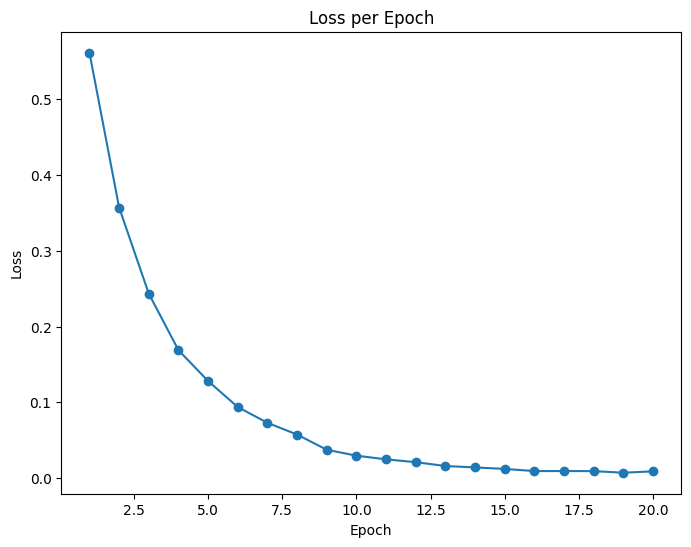

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.show()

In [33]:
def evaluate_model(data_loader, model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            for label, prediction, mask in zip(labels, predictions, attention_mask):
                active_labels = label[mask == 1].tolist()
                active_predictions = prediction[mask == 1].tolist()
                y_true.extend(active_labels)
                y_pred.extend(active_predictions)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, labels=list(label_map.values()), target_names=list(label_map.keys())))

evaluate_model(train_loader, model)

/tmp/ipykernel_23/658509426.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(self.labels[idx]),


Classification Report:
                precision    recall  f1-score   support

             O       0.90      1.00      0.95     19417
      B-Person       1.00      0.99      1.00       223
      I-Person       0.64      1.00      0.78       200
B-Organization       0.99      1.00      0.99       573
I-Organization       0.63      1.00      0.77       438
  B-Technology       0.99      1.00      0.99       373
  I-Technology       0.57      1.00      0.73       312
    B-Datetime       0.97      1.00      0.99        68
    I-Datetime       0.79      1.00      0.88        33

     micro avg       0.89      1.00      0.94     21637
     macro avg       0.83      1.00      0.90     21637
  weighted avg       0.90      1.00      0.94     21637



# Test

In [49]:
def extract_entities(sentence, model, tokenizer, label_map_rev, max_length=128):
    model.eval()
    inputs = tokenizer(
        sentence.split(),
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        is_split_into_words=True,
        padding="max_length",
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    
    entities = []
    current_entity = {"type": None, "tokens": []}
    for token, pred in zip(tokens, predictions):
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue
        label = label_map_rev.get(pred, "O")
        if label.startswith("B-"):
            if current_entity["type"]:
                entities.append(current_entity)
            current_entity = {"type": label[2:], "tokens": [token]}
        elif label.startswith("I-") and current_entity["type"] == label[2:]:
            current_entity["tokens"].append(token)
        else:
            if current_entity["type"]:
                entities.append(current_entity)
            current_entity = {"type": None, "tokens": []}

    if current_entity["type"]:
        entities.append(current_entity)

    results = {}
    for entity in entities:
        entity_text = tokenizer.convert_tokens_to_string(entity["tokens"]).replace("##", "").strip()
        results.setdefault(entity["type"], []).append(entity_text)
    return results

In [50]:

test_sentence = "Rất khó làm chủ về độ chính xác và đồng bộ của các phần tử khi phát và thu, lượng dữ liệu cần xử lý cũng tăng gấp nhiều lần, ông Trần Hoàng Việt, trưởng phòng Công nghệ ăng-ten mảng pha chủ động của VHT, cho biết."
results = extract_entities(test_sentence, model, tokenizer, label_map_rev)

print("Kết quả nhận dạng thực thể:")
for entity_type, entities in results.items():
    print(f"{entity_type.lower()}: {', '.join(entities)}")

Kết quả nhận dạng thực thể:
person: Trần Hoàng Việt@@
organization: VHT@@


In [51]:

test_sentence = "Trong đó, Lumiere có khả năng tạo video được cho là tốt hơn Sora của OpenAI trong giai đoạn thử nghiệm cũng như phiên bản Gemini mới với khả năng lý luận."
results = extract_entities(test_sentence, model, tokenizer, label_map_rev)

print("Kết quả nhận dạng thực thể:")
for entity_type, entities in results.items():
    print(f"{entity_type.lower()}: {', '.join(entities)}")

Kết quả nhận dạng thực thể:
technology: Lumiere, Sora, Gemini
